# Install and import packages

---

In [0]:
! pip install captum

In [0]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from captum.attr import IntegratedGradients

from itertools import chain, combinations
import scipy.special

import seaborn as sns

# Load, clean and pre-process data

---

In [0]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

In [0]:
# Some code for data pre-processing and cleaning and the model structure borrowed from:
# https://www.tensorflow.org/tutorials/keras/regression 

column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
print(dataset.head())

dataset = dataset.dropna()
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
column_names = column_names[:-1] + ['Europe', 'Japan', 'USA']
print(column_names)

dataset.head()

    MPG  Cylinders  Displacement  ...  Acceleration  Model Year  Origin
0  18.0          8         307.0  ...          12.0          70       1
1  15.0          8         350.0  ...          11.5          70       1
2  18.0          8         318.0  ...          11.0          70       1
3  16.0          8         304.0  ...          12.0          70       1
4  17.0          8         302.0  ...          10.5          70       1

[5 rows x 8 columns]
['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Europe', 'Japan', 'USA']


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1


In [0]:
# TEST
np.set_printoptions(suppress=True)
np.array(dataset)[0, :]

array([  18.,    8.,  307.,  130., 3504.,   12.,   70.,    0.,    0.,
          1.])

Prepare train and test data

In [0]:
# Split into train and test set
X_train = dataset.sample(frac=0.8,random_state=0)
X_test = dataset.drop(train_dataset.index)
y_train = np.array(X_train.pop('MPG'))
y_test = np.array(X_test.pop('MPG'))

# Rescale data to [0, 1]
X_train = np.array((X_train - X_train.min())/(X_train.max() - X_train.min()))
X_test = np.array((X_test - X_test.min())/(X_test.max() - X_test.min()))
# normalized_df=(df-df.min())/(df.max()-df.min())
#X_train = np.array((X_train-X_train.mean())/X_train.std())
#X_test = np.array((X_test-X_test.mean())/X_test.std())

# Convert to tensors
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).view(-1, 1).float()
y_test = torch.tensor(y_test).view(-1, 1).float()

In [0]:
# TODO plot each feature agains target
# ....

# PyTorch model for fuel efficiency prediction

---

Build and train simple PyTorch model

In [0]:
class CarFuelEfficiency(nn.Module):
    def __init__(self):
        super().__init__()
        self.dense1 = nn.Linear(X_train.shape[-1], 64)
        self.relu1 = nn.ReLU()
        self.dense2 = nn.Linear(64, 64)
        self.relu2 = nn.ReLU()         
        self.out = nn.Linear(64, 1)
        
    def forward(self, input):
        x = self.relu1(self.dense1(input))
        x = self.relu2(self.dense2(x))
        return self.out(x)

In [0]:
# Instantiate
model = CarFuelEfficiency()
# model.train()
model.training

True

Training parameters

In [0]:
# Parameters
learning_rate = 0.001
batch_size = 10
num_epochs = 1000 

Data serving

In [0]:
datasets = torch.utils.data.TensorDataset(X_train, y_train)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=batch_size, shuffle=True)

Train model

---

In [0]:
# Train function
criterion = nn.MSELoss(reduction='sum')
def train_model(model, num_epochs=num_epochs):
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_iter:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            # Compute gradients
            loss.backward()
            running_loss += loss.item()
            # Update weights
            optimizer.step()

        if epoch % 20 == 0:    
            print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %
                  (epoch + 1, num_epochs, running_loss))
        running_loss = 0.0  

In [0]:
train_model(model, num_epochs=num_epochs)

Epoch [1]/[1000] running accumulative loss across all batches: 124818.112
Epoch [21]/[1000] running accumulative loss across all batches: 3821.068
Epoch [41]/[1000] running accumulative loss across all batches: 2759.980
Epoch [61]/[1000] running accumulative loss across all batches: 2610.801
Epoch [81]/[1000] running accumulative loss across all batches: 2480.229
Epoch [101]/[1000] running accumulative loss across all batches: 2372.788
Epoch [121]/[1000] running accumulative loss across all batches: 2344.434
Epoch [141]/[1000] running accumulative loss across all batches: 2327.836
Epoch [161]/[1000] running accumulative loss across all batches: 2262.635
Epoch [181]/[1000] running accumulative loss across all batches: 2184.414
Epoch [201]/[1000] running accumulative loss across all batches: 2176.615
Epoch [221]/[1000] running accumulative loss across all batches: 2181.466
Epoch [241]/[1000] running accumulative loss across all batches: 2123.569
Epoch [261]/[1000] running accumulative lo

# Predict 

---

In [0]:
test_predictions = model(X_test)

In [0]:
# TEST err
a = test_predictions
a = ((test-y_test)/y_test).flatten()
a = a.clone().detach().numpy()
np.mean(a)

-0.030548235

In [0]:
# Convert to array
y_true_arr = y_test.clone().detach().numpy().flatten()
y_pred_arr = test_predictions.clone().detach().numpy().flatten()

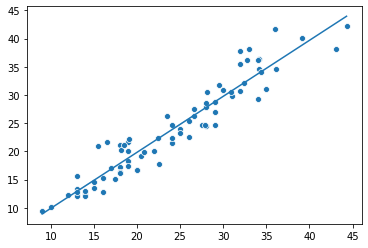

In [0]:
sns.scatterplot(x=y_true_arr, y=y_pred_arr)

# fit a line (ax+b)
line_coefs = np.polyfit(y_true_arr, y_pred_arr, 1)
y_line = list(map(lambda x: line_coefs[0]*x+line_coefs[1], y_true_arr))

sns.lineplot(y_true_arr, y_line)

# Explain with Captum Integrated Gradients

In [0]:
ig = IntegratedGradients(model)

Try various baselines

In [0]:
# Zeros
baseline_0 = torch.tensor(np.zeros(X_test.shape[-1])[None]).float()
print(baseline_0)

# Mean for each column
baseline_mean = np.apply_along_axis(lambda x: x.mean(), 0, X_test)
baseline_mean = torch.tensor(baseline_mean[None]).float()
print(baseline_mean)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[0.4897, 0.3659, 0.3014, 0.4193, 0.5087, 0.5256, 0.1538, 0.2179, 0.6282]])


Expected value: model output for the reference (baseline) sample

In [0]:
expected_value_0 = model(baseline_0)
expected_value_mean = model(baseline_mean)

print("expected_value_0: {}, expected_value_mean: {}".format(expected_value_0, expected_value_mean))

expected_value_0: tensor([[20.1446]], grad_fn=<AddmmBackward>), expected_value_mean: tensor([[17.3213]], grad_fn=<AddmmBackward>)


Data samples to explain

In [0]:
X_samples = X_test

X_samples_predictions = model(X_samples)

# Difference to explain: difference from the expected value for 0 and mean baselines
diff_baseline_0 = (X_samples_predictions - expected_value_0).view(-1).clone().detach().numpy()
diff_baseline_mean = (X_samples_predictions - expected_value_mean).view(-1).clone().detach().numpy()

In [0]:
diff_baseline_mean

array([-2.7369986, -7.251899 ], dtype=float32)

Calculate feature attributions

In [0]:
# baseline_0
ig_attribution_baseline_0 = ig.attribute(X_samples, n_steps=200,
                                         baselines=baseline_0) # n_steps
ig_attribution_baseline_0 = ig_attribution_baseline_0.clone().detach().numpy()
sum_attributions_for_samples_0 = ig_attribution_baseline_0.sum(axis=1)
sum_attributions_for_samples_0[0:2]

array([ -5.626402, -10.03682 ], dtype=float32)

In [0]:
# baseline_mean
ig_attribution_baseline_mean = ig.attribute(X_samples, n_steps=100, baselines=baseline_mean)
ig_attribution_baseline_mean = ig_attribution_baseline_mean.clone().detach().numpy()
sum_attributions_for_samples_mean = ig_attribution_baseline_mean.sum(axis=1)
sum_attributions_for_samples_mean[0:2]

array([-2.754576, -7.254574], dtype=float32)

Attributions sum up to the difference between model's output and the expected value (model's output for the baseline):

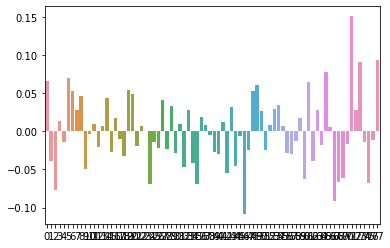

In [0]:
# TODO: 50 steps and 200 steps ...
explain_0 = diff_baseline_0 - sum_attributions_for_samples_0

# TODO: diff number of steps

# How ig explains the difference (should be -> 0)
sns.barplot(x=list(range(len(explain_0))), y=explain_0)

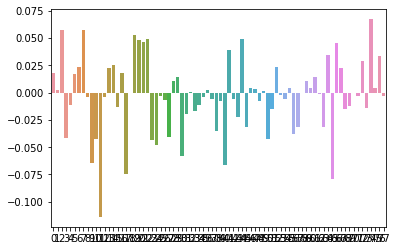

In [0]:
explain_mean = diff_baseline_mean - sum_attributions_for_samples_mean

# np.max(abs(explain_mean))

# TODO: diff number of steps

# How ig explains the difference (should be -> 0)
sns.barplot(x=list(range(len(explain_mean))), y=explain_mean)

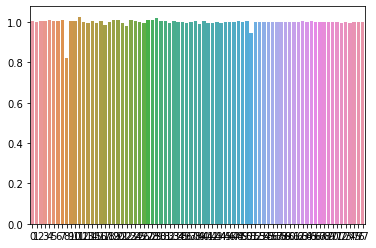

In [0]:
# Relative to the value explained
# Portion of the difference explained by ig

sns.barplot(x=list(range(len(explain_mean))), y=sum_attributions_for_samples_mean/diff_baseline_mean)

# or: explain_mean/diff (close to 0)

In [0]:
# TODO explore samples NOT EXPLAINED in BOTH and SHAP
# same samples or different

## Plot attributions

Mean attributions for features across samples

In [0]:
# Helper function

def plot_chart(y, ax, title):
    chart = sns.barplot(x = column_names[1:], 
                        y=y, 
                        ax=ax, color='#1f77b4')
    chart.set_title(title)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

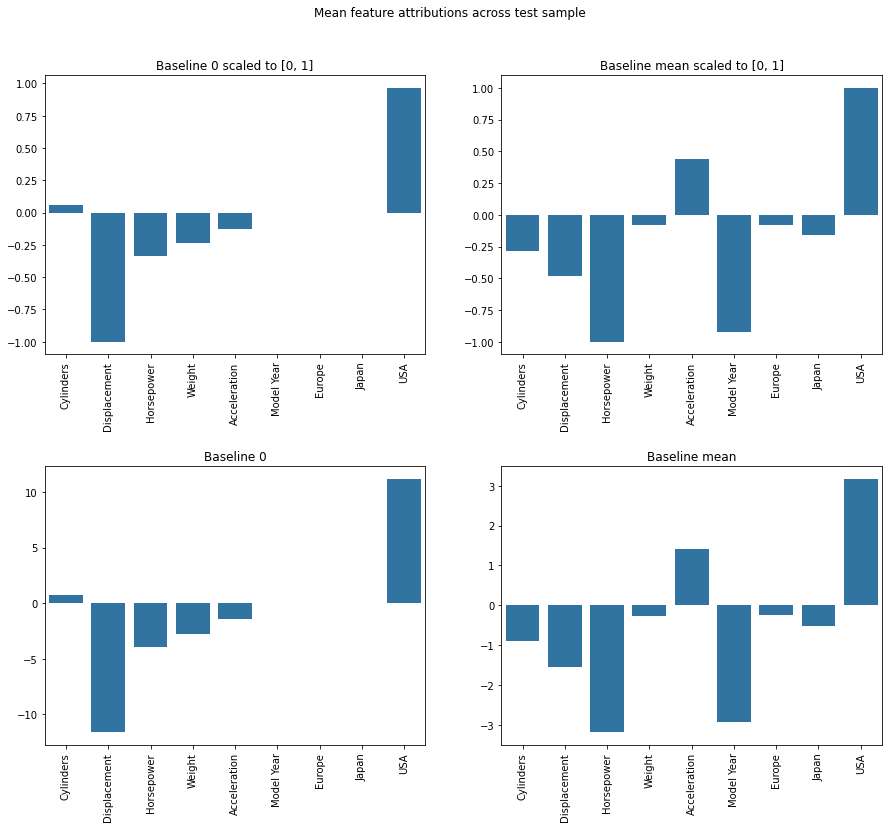

In [0]:
attributions_0 = ig_attribution_baseline_0.mean(axis=0) 
attributions_0_norm = attributions_0 / max(abs(attributions_0))

attributions_mean = ig_attribution_baseline_mean.mean(axis=0) 
attributions_mean_norm = attributions_mean / max(abs(attributions_mean))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2) #, sharey=True)
fig.set_size_inches(15.0, 12.0)

plt.subplots_adjust(top=0.9, wspace=0.2, hspace=0.4)
fig.suptitle('Mean feature attributions across test sample')

plot_chart(attributions_0_norm, ax1, "Baseline 0 scaled to [0, 1]")
plot_chart(attributions_mean_norm, ax2, "Baseline mean scaled to [0, 1]")
plot_chart(attributions_0, ax3, "Baseline 0")
plot_chart(attributions_mean, ax4, "Baseline mean")

plt.ioff()    

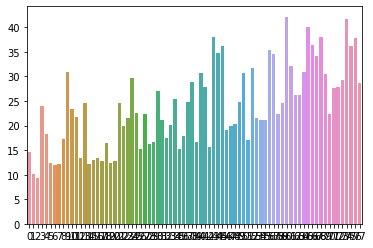

In [0]:
sns.barplot(x=list(range(len(test_predictions.view(-1).clone().detach().numpy()))), 
            y=test_predictions.view(-1).clone().detach().numpy())

# Explain with SHAP values

---

Now let's try to explain the difference between model's output for a sample and the expected value with a simple straightforwad implementation of the SHAP algorithm.

Toy implementation of SHAP values

---


Kernel SHAP is model-agnostic and only requires a function returning the score for a given sample. This is a naive straightforward implementation of the Shapley values algorithm for one-actor coalitions.

__[Wiki Shapley value](https://en.wikipedia.org/wiki/Shapley_value)__


<center>
$\varphi _{i}(v)={\frac {1}{N}}\sum _{S\subseteq N\setminus \{i\}}{\binom {N-1}{|S|}}^{-1}(v(S\cup \{i\})-v(S))$
</center>

In [0]:
def calculate_simple_shap(X_sample, X_baseline, model_fn):
    '''Calculates shap values for an array of samples'''

    def shap_one_sample(x_sample):
        '''Calculates shap values for one sample.'''

        N = X_samples.shape[-1]

        def shap_i(x_sample, i: int) -> float:
            '''Calculates shap values for the i-th element of a sample.'''
                
            all_subsets_minus_i = list(filter(lambda x: x[i] ==0, all_subsets))

            sum_i = 0
            for s in all_subsets_minus_i:
                model_output_si = model_output_all_subsets[tuple(x if ii != i else 1 
                                                            for ii, x in enumerate(s))]
                model_output_s = model_output_all_subsets[s]                                  
                v_si_subtract_v_s = model_output_si - model_output_s
                s_len = len([x for x in s if x == 1])
                sum_i += v_si_subtract_v_s / binom_s_all[s_len]

            return sum_i / N


        # Helper functions        
        def subset2inputs(x_sample, X_baseline, subset): 
            '''Elements in x_sample absent from the current subset 
            get replaced by reference values'''    
            return [ref if s==0 else x for x, ref, s 
                    in [(x, ref, s) for x, ref, s 
                        in zip(x_sample, X_baseline, subset)]]

        def tpl2indx(tpl, max_len):
            return tuple(1 if i in tpl else 0 for i in range(max_len+1))                     


        # Powerset of N elements as tuples of zeros and ones of length N
        powerset_n = chain.from_iterable(combinations(range(N), r) 
                                         for r in range(N + 1)) 
        all_subsets = [tpl2indx(x, N-1) for x in powerset_n]  
        binom_s_all = dict(zip(range(N), [int(scipy.special.binom(N-1, s)) 
                                          for s in range(N+1)]))

        # Precalculate model output for all subsets
        model_input_all_subsets = [subset2inputs(x_sample, X_baseline, s) 
                                          for s in all_subsets]
        model_output_all_subsets = dict(zip(all_subsets, 
                                            model_fn(model_input_all_subsets)))

        return np.array([shap_i(x_sample, i) for i in range(N)])

    # Return values for all samples
    return np.array([shap_one_sample(x) for x in X_samples])

In [0]:
def model_car_fuel_efficiency(x):
    return model(torch.tensor(x)).reshape(-1).clone().detach().numpy()

model_fn = model_car_fuel_efficiency

# TAKE FROM PREVIOUS ... TODO
X_baseline_mean = np.apply_along_axis(lambda x: x.mean(), 0, X_train)

expected_value_mean = model_fn(X_baseline_mean)

# x_sample = X_test[0].numpy()

X_samples = X_test.numpy() #X_test[0:3, :].numpy()

In [0]:
expected_value_mean

array([17.190191], dtype=float32)

In [0]:
shap_values_simple = calculate_simple_shap(X_samples, X_baseline, model_fn)

Plot shap values

In [0]:
shap_values_simple.shape

(78, 9)

In [0]:
np.round(max(abs(np.sum(shap_values_simple, axis=1) + expected_value - model_fn(X_samples))), 5)

# PLOT HOW THEY EXPLAIN

0.0

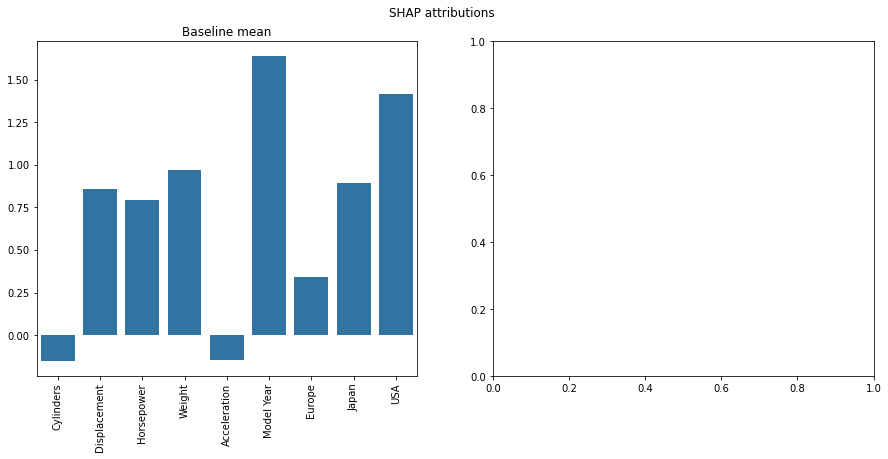

In [0]:
attributions_mean_shap = shap_values_simple.mean(axis = 0)

fig, (ax1, ax2) = plt.subplots(ncols=2) 
fig.set_size_inches(15.0, 6.0)

plt.subplots_adjust(top=0.9)
fig.suptitle('SHAP attributions')

plot_chart(attributions_mean_shap, ax1, "Baseline mean")

plt.ioff()    

In [0]:
# TODO Glove and shap library

In [0]:
def score_glove_game(x):
    return [1*(any(xx==1 for xx in row[0:2]) and row[2]==1) for row in x]

model_fn = score_glove_game

X_baseline = [0, 0, 0]

expected_value = model_fn([X_baseline])

x_sample = np.array([1, 1, 1])

X_samples =np.array([[1, 1, 1]])

In [0]:
shap_glove = calculate_simple_shap(X_samples, X_baseline, model_fn)

In [630]:
shap_glove

array([[0.16666667, 0.16666667, 0.66666667]])

In the Wiki example:

$\varphi _{1}(v)=\!\left({\frac {1}{6}}\right)(1)={\frac {1}{6}}$

$ \varphi _{2}(v)=\varphi _{1}(v)={\frac {1}{6}}$

$\varphi _{3}(v)={\frac {4}{6}}={\frac {2}{3}}$

# References 

---

https://github.com/pytorch/captum/blob/master/tutorials/House_Prices_Regression_Interpret.ipynb

https://captum.ai/docs/extension/integrated_gradients

https://www.tensorflow.org/tutorials/keras/regression


# TEST ...

---

In [0]:
sns.load_dataset("tips")

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
